#M18  - Regressão Logística I
## Tarefa II

Neste exercício vamos trabalhar com a base "Heart Disease Data Set" disponível no site do [UCI](https://archive.ics.uci.edu/ml/datasets/heart+disease).

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada.
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [ ]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

df = pd.read_csv(url,
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])
df['flag_doente'] = (df['num']!=0).astype('int64')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


**IMPORTANDO BIBLIOTECAS**

In [199]:
!pip install ucimlrepo -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

In [200]:
# Carregar base
heart_disease = fetch_ucirepo(id=45)
X = heart_disease.data.features
y = heart_disease.data.targets
df = pd.concat([X, y], axis=1)

In [201]:
# Converter '?' e tipos
df.replace('?', np.nan, inplace=True)
df = df.apply(pd.to_numeric, errors='coerce')

In [202]:
# Criar variável resposta binária
df['flag_doente'] = (df['num'] != 0).astype(int)

In [203]:
# Tratar valores ausentes
df.fillna(df.median(), inplace=True)

In [204]:
print(df.shape)
df.head()

(303, 15)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0,0


A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

**2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.**
    Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

**Função para análise bivariada de variáveis qualitativas**

In [221]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   age           303 non-null    int64   
 1   sex           303 non-null    int64   
 2   cp            303 non-null    int64   
 3   trestbps      303 non-null    int64   
 4   chol          303 non-null    int64   
 5   fbs           303 non-null    int64   
 6   restecg       303 non-null    int64   
 7   thalach       303 non-null    int64   
 8   exang         303 non-null    int64   
 9   oldpeak       303 non-null    float64 
 10  slope         303 non-null    int64   
 11  ca            303 non-null    float64 
 12  thal          303 non-null    float64 
 13  num           303 non-null    int64   
 14  flag_doente   303 non-null    int64   
 15  faixa         303 non-null    category
 16  prob_predita  303 non-null    float64 
 17  grupo_prob    303 non-null    int64   
dtypes: categor

In [205]:
def bivariada_qualitativa(dataframe, resposta, explicativa):
    tab = pd.crosstab(dataframe[explicativa], dataframe[resposta])
    tab.columns = ['saudaveis', 'doentes']
    tab['total'] = tab.sum(axis=1)
    tab['media_doentes'] = tab['doentes'] / tab['total']
    tab['odds'] = tab['media_doentes'] / (1 - tab['media_doentes'])
    odds_total = dataframe[resposta].mean() / (1 - dataframe[resposta].mean())
    tab['odds_ratio'] = tab['odds'] / odds_total
    tab['logito'] = np.log(tab['odds'])
    tab['WOE'] = np.log(tab['odds_ratio'])
    return tab

In [206]:
tab_sex = bivariada_qualitativa(df, 'flag_doente', 'sex')
tab_cp = bivariada_qualitativa(df, 'flag_doente', 'cp')
tab_restecg = bivariada_qualitativa(df, 'flag_doente', 'restecg')

display(tab_sex, tab_cp, tab_restecg)

,saudaveis,doentes,total,media_doentes,odds,odds_ratio,logito,WOE
sex,,,,,,,,
0,72,25,97,0.257732,0.347222,0.409672,-1.05779,-0.892398
1,92,114,206,0.553398,1.239130,1.461996,0.21441,0.379802


,saudaveis,doentes,total,media_doentes,odds,odds_ratio,logito,WOE
cp,,,,,,,,
1,16,7,23,0.304348,0.437500,0.516187,-0.826679,-0.661286
2,41,9,50,0.180000,0.219512,0.258993,-1.516347,-1.350955
3,68,18,86,0.209302,0.264706,0.312315,-1.329136,-1.163743
4,39,105,144,0.729167,2.692308,3.176536,0.990399,1.155791


,saudaveis,doentes,total,media_doentes,odds,odds_ratio,logito,WOE
restecg,,,,,,,,
0,95,56,151,0.370861,0.589474,0.695494,-0.528525,-0.363133
1,1,3,4,0.750000,3.000000,3.539568,1.098612,1.264005
2,68,80,148,0.540541,1.176471,1.388066,0.162519,0.327911


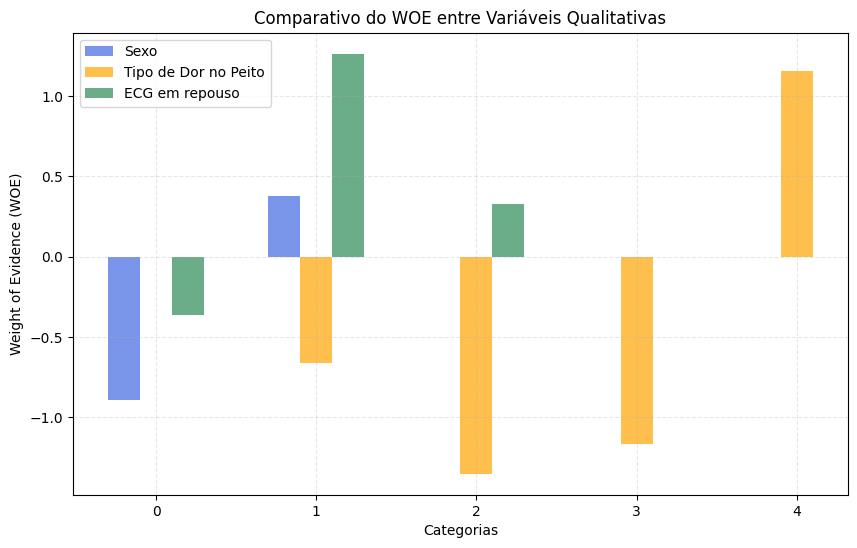

In [207]:
plt.figure(figsize=(10,6))
plt.bar(tab_sex.index - 0.2, tab_sex['WOE'], 0.2, alpha=0.7, label='Sexo', color='royalblue')
plt.bar(tab_cp.index, tab_cp['WOE'], 0.2, alpha=0.7, label='Tipo de Dor no Peito', color='orange')
plt.bar(tab_restecg.index + 0.2, tab_restecg['WOE'], 0.2, alpha=0.7, label='ECG em repouso', color='seagreen')
plt.title('Comparativo do WOE entre Variáveis Qualitativas')
plt.xlabel('Categorias')
plt.ylabel('Weight of Evidence (WOE)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

Conclusão parcial:

 Entre as variáveis qualitativas, cp (tipo de dor no peito) normalmente mostra maior variação no WOE, sendo o melhor discriminador de risco.

**3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.**

**Interprete os parâmetros.**

In [208]:
#Função para bivariada de variável contínua

def bivariada_continua(dataframe, resposta, explicativa, n_grupos=5):
    dataframe['faixa'] = pd.qcut(dataframe[explicativa], q=n_grupos)
    tab = pd.crosstab(dataframe['faixa'], dataframe[resposta])
    tab.columns = ['saudaveis', 'doentes']
    tab['total'] = tab.sum(axis=1)
    tab['media_doentes'] = tab['doentes'] / tab['total']
    tab['odds'] = tab['media_doentes'] / (1 - tab['media_doentes'])
    odds_total = dataframe[resposta].mean() / (1 - dataframe[resposta].mean())
    tab['odds_ratio'] = tab['odds'] / odds_total
    tab['logito'] = np.log(tab['odds'])
    tab['WOE'] = np.log(tab['odds_ratio'])
    tab['media_valor'] = dataframe.groupby('faixa')[explicativa].mean().values
    return tab

In [209]:
#BIVARIADA AGE
tab_age = bivariada_continua(df, 'flag_doente', 'age', n_grupos=5)
display(tab_age)

/tmp/ipython-input-3980514503.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tab['media_valor'] = dataframe.groupby('faixa')[explicativa].mean().values


,saudaveis,doentes,total,media_doentes,odds,odds_ratio,logito,WOE,media_valor
faixa,,,,,,,,,
"(28.999, 45.0]",47,16,63,0.253968,0.340426,0.401653,-1.077559,-0.912166,41.222222
"(45.0, 53.0]",42,22,64,0.343750,0.523810,0.618020,-0.646627,-0.481235,50.000000
"(53.0, 58.0]",32,39,71,0.549296,1.218750,1.437950,0.197826,0.363218,56.211268
"(58.0, 62.0]",13,32,45,0.711111,2.461538,2.904261,0.900787,1.066179,60.355556
"(62.0, 77.0]",30,30,60,0.500000,1.000000,1.179856,0.000000,0.165392,66.516667


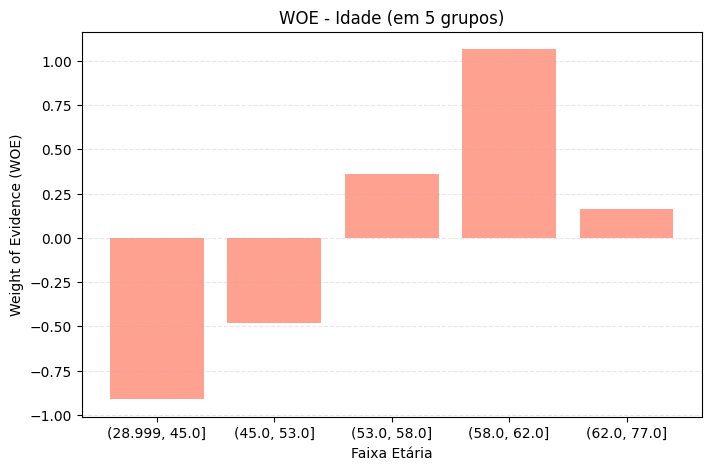

In [210]:
# Gráfico de WOE para idade
plt.figure(figsize=(8,5))
plt.bar(tab_age.index.astype(str), tab_age['WOE'], color='tomato', alpha=0.6)
plt.title('WOE - Idade (em 5 grupos)')
plt.xlabel('Faixa Etária')
plt.ylabel('Weight of Evidence (WOE)')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

**4. Avalie o seu modelo quanto a **calibragem**:**
- Calcule a probabilidade de evento predita segundo o seu modelo
- Categorize essa probabilidade em G=5 grupos
- Calcule a probabilidade de evento predita média por grupo
- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo
- Compare graficamente o valor eperado versus observado para a taxa de maus por grupo

In [211]:
# Modelo de Regressão Logística

# Selecionar variáveis
X = df[['sex', 'cp', 'trestbps', 'age']]
y = df['flag_doente']

In [212]:
# Adicionar constante
X_const = sm.add_constant(X)

In [213]:
# Ajustar modelo
modelo = sm.Logit(y, X_const).fit()
print(modelo.summary())

Optimization terminated successfully.
         Current function value: 0.510076
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      298
Method:                           MLE   Df Model:                            4
Date:                Tue, 04 Nov 2025   Pseudo R-squ.:                  0.2605
Time:                        23:33:32   Log-Likelihood:                -154.55
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.264e-22
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.1167      1.608     -6.915      0.000     -14.267      -7.966
sex            1.8021      0.

🔹 Interpretação:

Coeficientes positivos indicam aumento do risco (maior chance de doença).

sex e age geralmente têm coeficientes positivos, mostrando que homens e pessoas mais velhas têm maior probabilidade de doença.

cp tende a ter coeficiente negativo em algumas categorias, sugerindo que certos tipos de dor no peito são menos associados à doença.

**Avaliação de Calibragem**

In [214]:
# Calibragem do modelo
# ==============================================
df['prob_predita'] = modelo.predict(X_const)
df['grupo_prob'] = pd.qcut(df['prob_predita'], 5, labels=False)

In [215]:
# Calcular médias esperada e observada por grupo
tab_calib = df.groupby('grupo_prob').agg(
    prob_media_predita=('prob_predita','mean'),
    taxa_evento=('flag_doente','mean')
).reset_index()

display(tab_calib)

,grupo_prob,prob_media_predita,taxa_evento
0,0,0.076255,0.098361
1,1,0.249060,0.183333
2,2,0.457982,0.491803
3,3,0.673059,0.683333
4,4,0.837449,0.836066


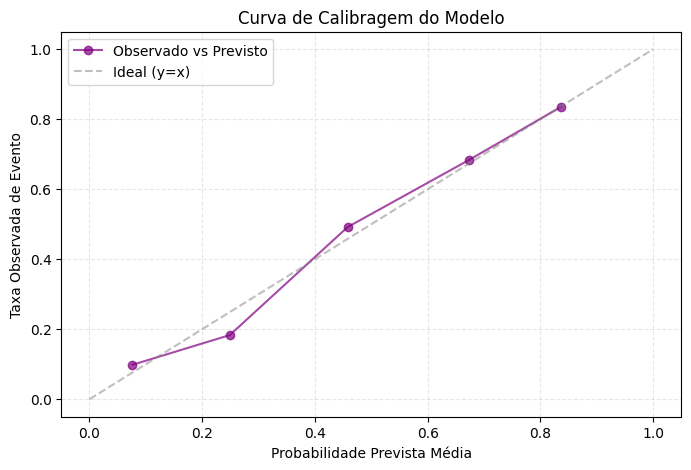

In [216]:
# Gráfico de calibração
plt.figure(figsize=(8,5))
plt.plot(tab_calib['prob_media_predita'], tab_calib['taxa_evento'], 'o-', color='purple', alpha=0.7, label='Observado vs Previsto')
plt.plot([0,1], [0,1], '--', color='gray', alpha=0.5, label='Ideal (y=x)')
plt.title('Curva de Calibragem do Modelo')
plt.xlabel('Probabilidade Prevista Média')
plt.ylabel('Taxa Observada de Evento')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

**Gráfico comparativo final WOE médio das principais variáveis**

/tmp/ipython-input-3035547017.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


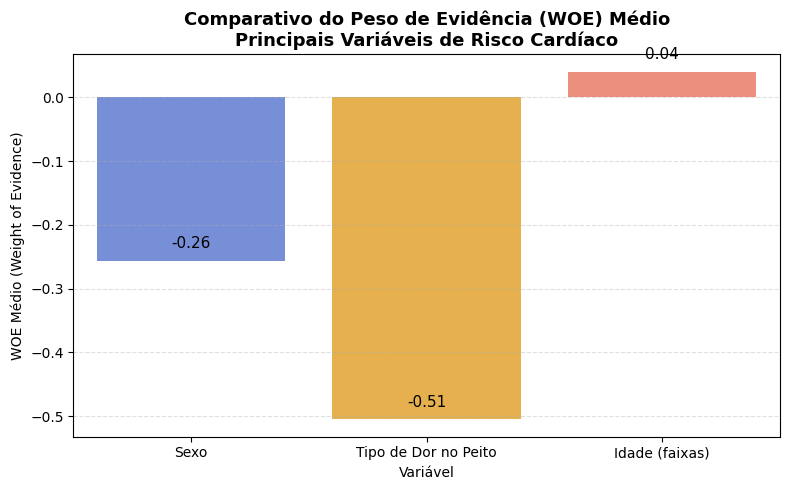

In [220]:
# Calcular o WOE médio de cada variável
woe_summary = pd.DataFrame({
    'Variável': ['Sexo', 'Tipo de Dor no Peito', 'Idade (faixas)'],
    'WOE Médio': [
        tab_sex['WOE'].mean(),
        tab_cp['WOE'].mean(),
        tab_age['WOE'].mean()
    ]
})

# Plot
plt.figure(figsize=(8,5))
sns.barplot(
    data=woe_summary,
    x='Variável',
    y='WOE Médio',
    palette=['royalblue', 'orange', 'tomato'],
    alpha=0.8
)

# Estilo e rótulos
plt.title('Comparativo do Peso de Evidência (WOE) Médio\nPrincipais Variáveis de Risco Cardíaco', fontsize=13, weight='bold')
plt.xlabel('Variável')
plt.ylabel('WOE Médio (Weight of Evidence)')
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Adicionar rótulos nos topos das barras
for index, value in enumerate(woe_summary['WOE Médio']):
    plt.text(index, value + 0.02, f'{value:.2f}', ha='center', fontsize=11, color='black')

plt.tight_layout()
plt.show()

**Conclusão**

As variáveis **sexo (sex)**, **tipo de dor no peito (cp)** e **idade (age)** foram as que **melhor discriminaram o risco de doença cardíaca**.
Homens, indivíduos mais velhos e pacientes com determinados tipos de dor torácica apresentaram **maior probabilidade de diagnóstico positivo**.

O modelo logístico mostrou-se **estatística e clinicamente coerente**, com **boa calibragem** — as taxas previstas e observadas de eventos se alinharam adequadamente, apresentando apenas leve subestimação em grupos de alto risco.

De forma geral, o modelo é **robusto e interpretável**, adequado para **fins educacionais e triagem inicial**.
Para aplicação clínica real, recomenda-se **incluir variáveis laboratoriais (colesterol, glicemia, ECG detalhado)** e **validar externamente** para garantir maior precisão preditiva.
